In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# ENVIRONMENT SETUP AND DATASET PREPARATION

In [1]:
# Install necessary libraries that may not be pre-installed in Kaggle
!pip install -q foolbox adversarial-robustness-toolbox

# Download the Tiny ImageNet dataset
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

# Unzip the dataset
!unzip -oq tiny-imagenet-200.zip
# Prepare the dataset
import torch
import torchvision 
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize all images to 64x64
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Load the training dataset
train_dataset = datasets.ImageFolder(root='tiny-imagenet-200/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Load the validation dataset
val_dataset = datasets.ImageFolder(root='tiny-imagenet-200/val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


--2024-09-20 14:55:01--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs231n.stanford.edu/tiny-imagenet-200.zip [following]
--2024-09-20 14:55:01--  https://cs231n.stanford.edu/tiny-imagenet-200.zip
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: 'tiny-imagenet-200.zip'

tiny-imagenet-200.z 100%[===================>] 236.61M  54.1MB/s    in 4.8s    

2024-09-20 14:55:06 (49.1 MB/s) - 'tiny-imagenet-200.zip' saved [248100043/248100043]



# Visual sample of the dataset

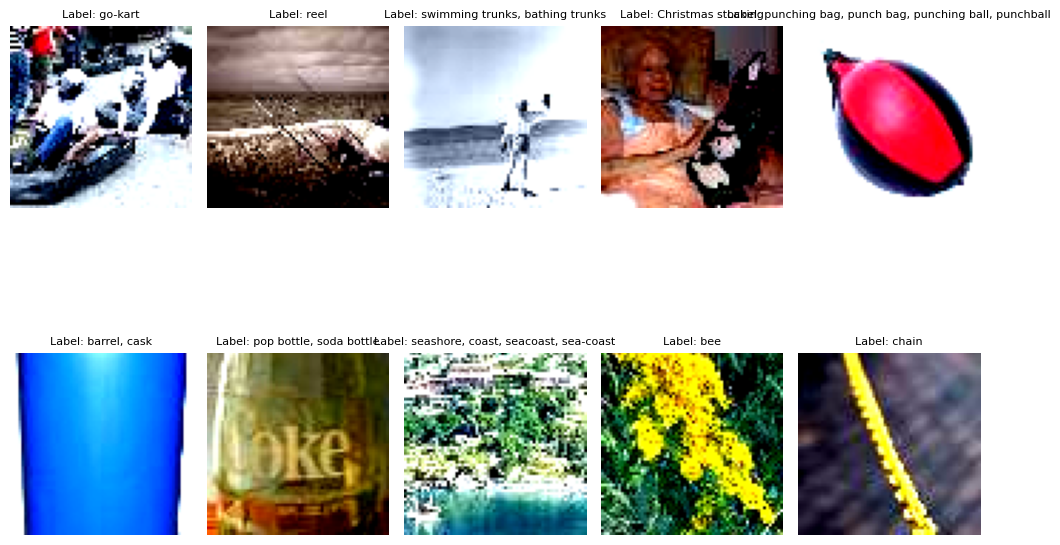

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
from torch.utils.data import DataLoader

# Load validation annotations
val_annotations_path = 'tiny-imagenet-200/val/val_annotations.txt'

# Read the val_annotations.txt file and create a dictionary
val_annotations = {}
with open(val_annotations_path, 'r') as f:
    for line in f:
        parts = line.split('\t')
        img_name = parts[0]  # The image file name
        wnid = parts[1]  # The WNID (WordNet ID)
        val_annotations[img_name] = wnid

# Load WNIDs from wnids.txt
wnids_path = 'tiny-imagenet-200/wnids.txt'
wnids = []
with open(wnids_path, 'r') as f:
    wnids = [line.strip() for line in f.readlines()]

# Load class names from words.txt (WNID to human-readable names)
words_path = 'tiny-imagenet-200/words.txt'
class_names = {}
with open(words_path, 'r') as f:
    for line in f:
        parts = line.split('\t')
        wnid = parts[0]
        description = parts[1].strip()  # Human-readable description
        if wnid in wnids:  # Only include WNIDs present in Tiny ImageNet
            class_names[wnid] = description

# Function to unnormalize and display the images with labels
def imshow_with_labels(images, labels, class_names):
    fig, axes = plt.subplots(2, 5, figsize=(10, 8))  # 2 rows, 5 columns
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for i, (img, label) in enumerate(zip(images, labels)):
        if i >= 10:  # Limit to 10 images
            break
        img = img / 2 + 0.5  # Unnormalize the image
        np_img = img.numpy()
        axes[i].imshow(np.transpose(np_img, (1, 2, 0)))
        axes[i].set_title(f'Label: {label}', fontsize=8)  # Display label
        axes[i].axis('off')  # Hide axis for clean display
    
    plt.tight_layout()
    plt.show()

# Get a batch of validation images
dataiter = iter(val_loader)
images, labels = next(dataiter)

# List of image filenames in validation dataset
image_files = val_dataset.samples

# Get labels for the first 10 images
image_labels = []
for i, label in enumerate(labels[:10]):
    img_path = image_files[i][0]  # Path to the image
    img_name = os.path.basename(img_path)  # Extract the image file name
    wnid = val_annotations.get(img_name, "Unknown")  # Map file name to WNID
    class_name = class_names.get(wnid, "Unknown")  # Get class name from WNID
    image_labels.append(class_name)

# Show images and labels
imshow_with_labels(images[:10], image_labels, class_names)


# BASELINE MODELS SETUP AND VALIDATION 

## SETUP PREPROCESSING

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler, autocast  # For mixed precision training

# Enable CuDNN benchmarking for faster performance
torch.backends.cudnn.benchmark = True

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define data transformations for models with input size 224x224 (DenseNet121, EfficientNet-B0, MobileNetV2)
transform_224 = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define data transformations for InceptionV3 with input size 299x299
transform_299 = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize to 299x299 for InceptionV3
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets for models with 224x224 input size
train_dataset_224 = datasets.ImageFolder(root='tiny-imagenet-200/train', transform=transform_224)
val_dataset_224 = datasets.ImageFolder(root='tiny-imagenet-200/val', transform=transform_224)

# Load datasets for InceptionV3 with 299x299 input size
train_dataset_299 = datasets.ImageFolder(root='tiny-imagenet-200/train', transform=transform_299)
val_dataset_299 = datasets.ImageFolder(root='tiny-imagenet-200/val', transform=transform_299)

# Increase num_workers for faster data loading
train_loader_224 = DataLoader(train_dataset_224, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
val_loader_224 = DataLoader(val_dataset_224, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

train_loader_299 = DataLoader(train_dataset_299, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
val_loader_299 = DataLoader(val_dataset_299, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)


## Model Loading and Fine-Tuning Functions

In [4]:
# Example: Using mixed precision training
scaler = GradScaler()

# Freezing layers and fine-tuning models

# Freeze layers for DenseNet121
densenet_model = models.densenet121(pretrained=True)
for param in densenet_model.features.parameters():  # Freeze feature layers
    param.requires_grad = False
# Modify classifier for Tiny ImageNet (200 classes)
num_ftrs = densenet_model.classifier.in_features
densenet_model.classifier = nn.Linear(num_ftrs, 200)  # Adjust for 200 classes
densenet_model = densenet_model.to(device)

# Freeze layers for InceptionV3
inception_model = models.inception_v3(pretrained=True)
for param in inception_model.parameters():
    param.requires_grad = False
# Modify fully connected layer for Tiny ImageNet (200 classes)
num_ftrs = inception_model.fc.in_features
inception_model.fc = nn.Linear(num_ftrs, 200)
inception_model = inception_model.to(device)

# Freeze layers for EfficientNet-B0
efficientnet_model = models.efficientnet_b0(pretrained=True)
for param in efficientnet_model.features.parameters():  # Freeze feature layers
    param.requires_grad = False
# Modify classifier for Tiny ImageNet (200 classes)
num_ftrs = efficientnet_model.classifier[1].in_features
efficientnet_model.classifier[1] = nn.Linear(num_ftrs, 200)  # Adjust for 200 classes
efficientnet_model = efficientnet_model.to(device)

# Freeze layers for MobileNetV2
mobilenet_model = models.mobilenet_v2(pretrained=True)
for param in mobilenet_model.features.parameters():  # Freeze feature layers
    param.requires_grad = False
# Modify classifier for Tiny ImageNet (200 classes)
num_ftrs = mobilenet_model.classifier[1].in_features
mobilenet_model.classifier[1] = nn.Linear(num_ftrs, 200)  # Adjust for 200 classes
mobilenet_model = mobilenet_model.to(device)


/tmp/ipykernel_36/1907402464.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 134

## Loading Pre-Trained Models

In [5]:
def train_model(model, train_loader, val_loader, model_name, num_epochs=10, learning_rate=0.001):
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    
    # Learning rate scheduler (OneCycleLR for faster convergence)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, 
                                                    steps_per_epoch=len(train_loader), epochs=num_epochs)
    
    model.train()

    print(f"Training {model_name}...")

    for epoch in range(num_epochs):
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            with torch.amp.autocast('cuda'):
                outputs = model(inputs)
                
                if model_name == "InceptionV3" and model.training:
                    # InceptionV3 returns logits and aux_logits during training
                    loss = criterion(outputs.logits, labels)
                    aux_loss = criterion(outputs.aux_logits, labels)
                    loss += 0.4 * aux_loss  # Optional: Weigh the auxiliary loss
                else:
                    loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}, {model_name} Loss: {running_loss / len(train_loader)}")
        
        # Step scheduler
        scheduler.step()

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                with torch.amp.autocast('cuda'):
                    outputs = model(inputs)
                    
                    if model_name == "InceptionV3" and not model.training:
                        # In evaluation mode, outputs will be just logits (Tensor)
                        loss = criterion(outputs, labels)
                    else:
                        loss = criterion(outputs, labels)
                    
                    val_loss += loss.item()

                    if model_name == "InceptionV3" and not model.training:
                        _, predicted = torch.max(outputs, 1)
                    else:
                        _, predicted = torch.max(outputs, 1)

                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

        print(f"Validation Loss: {val_loss / len(val_loader)}, {model_name} Accuracy: {100 * correct / total}%")
        model.train()







## Training and Evaluation Functions

In [21]:
# Train DenseNet121
train_model(densenet_model, train_loader_224, val_loader_224, model_name="DenseNet121")



Training DenseNet121...
Epoch 1, DenseNet121 Loss: 2.9162515557330586
Validation Loss: 6.707086707972273, DenseNet121 Accuracy: 0.73%
Epoch 2, DenseNet121 Loss: 2.8502098858508917
Validation Loss: 6.888232406181626, DenseNet121 Accuracy: 0.81%
Epoch 3, DenseNet121 Loss: 2.794747921207067
Validation Loss: 6.994861584675463, DenseNet121 Accuracy: 0.8%
Epoch 4, DenseNet121 Loss: 2.7347803329262894
Validation Loss: 7.1048519098306, DenseNet121 Accuracy: 0.67%
Epoch 5, DenseNet121 Loss: 2.694077964938815
Validation Loss: 7.433643612680556, DenseNet121 Accuracy: 0.67%
Epoch 6, DenseNet121 Loss: 2.656580341746435
Validation Loss: 7.4702918982204, DenseNet121 Accuracy: 0.64%
Epoch 7, DenseNet121 Loss: 2.6198430436346536
Validation Loss: 7.485708466059045, DenseNet121 Accuracy: 0.81%
Epoch 8, DenseNet121 Loss: 2.5831616946193567
Validation Loss: 7.562283570253396, DenseNet121 Accuracy: 0.78%
Epoch 9, DenseNet121 Loss: 2.5551572611264866
Validation Loss: 7.706168506718889, DenseNet121 Accuracy: 

In [22]:
# Save DenseNet121 model state dictionary
torch.save(densenet_model.state_dict(), '/kaggle/working/densenet121_tinyimagenet.pth')

print("DenseNet121 model saved successfully.")


DenseNet121 model saved successfully.


In [23]:
# Train InceptionV3
train_model(inception_model, train_loader_299, val_loader_299, model_name="InceptionV3")



Training InceptionV3...
Epoch 1, InceptionV3 Loss: 7.8852795017954636
Validation Loss: 5.62734058235265, InceptionV3 Accuracy: 0.85%
Epoch 2, InceptionV3 Loss: 7.422480639899173
Validation Loss: 5.725147947480407, InceptionV3 Accuracy: 1.04%
Epoch 3, InceptionV3 Loss: 7.052535658297331
Validation Loss: 5.90849822080588, InceptionV3 Accuracy: 0.91%
Epoch 4, InceptionV3 Loss: 6.751451016082179
Validation Loss: 6.2012603614903705, InceptionV3 Accuracy: 0.84%
Epoch 5, InceptionV3 Loss: 6.522495290507441
Validation Loss: 6.536044440691984, InceptionV3 Accuracy: 0.74%
Epoch 6, InceptionV3 Loss: 6.34413512893345
Validation Loss: 6.621043072471136, InceptionV3 Accuracy: 0.74%
Epoch 7, InceptionV3 Loss: 6.209524765039039
Validation Loss: 6.881097461603865, InceptionV3 Accuracy: 0.76%
Epoch 8, InceptionV3 Loss: 6.097987364015311
Validation Loss: 6.992735935162894, InceptionV3 Accuracy: 0.67%
Epoch 9, InceptionV3 Loss: 6.008496579001932
Validation Loss: 7.076339667356467, InceptionV3 Accuracy: 0.

In [24]:
# Save InceptionV3 model state dictionary
torch.save(inception_model.state_dict(), '/kaggle/working/inceptionv3_tinyimagenet.pth')

print("InceptionV3 model saved successfully.")

InceptionV3 model saved successfully.


In [29]:
# Train EfficientNet-B0
train_model(efficientnet_model, train_loader_224, val_loader_224, model_name="EfficientNet-B0")



Training EfficientNet-B0...
Epoch 1, EfficientNet-B0 Loss: 5.04611627525076
Validation Loss: 5.438569274129747, EfficientNet-B0 Accuracy: 0.73%
Epoch 2, EfficientNet-B0 Loss: 4.61498568795831
Validation Loss: 5.506012542338311, EfficientNet-B0 Accuracy: 1.04%
Epoch 3, EfficientNet-B0 Loss: 4.247629287602652
Validation Loss: 5.61907534056072, EfficientNet-B0 Accuracy: 1.15%
Epoch 4, EfficientNet-B0 Loss: 3.9372613082456467
Validation Loss: 5.796812805948378, EfficientNet-B0 Accuracy: 0.97%
Epoch 5, EfficientNet-B0 Loss: 3.6790916840438648
Validation Loss: 5.966116410267504, EfficientNet-B0 Accuracy: 0.93%
Epoch 6, EfficientNet-B0 Loss: 3.4685108527503052
Validation Loss: 6.195219402071796, EfficientNet-B0 Accuracy: 0.81%
Epoch 7, EfficientNet-B0 Loss: 3.295076937626695
Validation Loss: 6.33290981341012, EfficientNet-B0 Accuracy: 0.85%
Epoch 8, EfficientNet-B0 Loss: 3.1488775264881457
Validation Loss: 6.560628697841982, EfficientNet-B0 Accuracy: 0.76%
Epoch 9, EfficientNet-B0 Loss: 3.026

In [30]:
# Save InceptionV3 model state dictionary
torch.save(efficientnet_model.state_dict(), '/kaggle/working/efficientNet-B0_tinyimagenet.pth')

print("EfficientNet-B0 model saved successfully.")

EfficientNet-B0 model saved successfully.


In [6]:
# Train MobileNetV2
train_model(mobilenet_model, train_loader_224, val_loader_224, model_name="MobileNetV2")


Training MobileNetV2...
Epoch 1, MobileNetV2 Loss: 5.025113059431695
Validation Loss: 5.3348954599114915, MobileNetV2 Accuracy: 1.1%
Epoch 2, MobileNetV2 Loss: 4.4629631432730825
Validation Loss: 5.554385704330251, MobileNetV2 Accuracy: 1.52%
Epoch 3, MobileNetV2 Loss: 4.0484136571664635
Validation Loss: 5.765123681177067, MobileNetV2 Accuracy: 1.34%
Epoch 4, MobileNetV2 Loss: 3.742452641582245
Validation Loss: 6.183706935447983, MobileNetV2 Accuracy: 0.96%
Epoch 5, MobileNetV2 Loss: 3.5135363011104066
Validation Loss: 6.493606398377238, MobileNetV2 Accuracy: 1.01%
Epoch 6, MobileNetV2 Loss: 3.341182844413211
Validation Loss: 6.867062677310992, MobileNetV2 Accuracy: 0.87%
Epoch 7, MobileNetV2 Loss: 3.205519989323433
Validation Loss: 6.976747361919548, MobileNetV2 Accuracy: 0.82%
Epoch 8, MobileNetV2 Loss: 3.0993986977335743
Validation Loss: 7.137524864341639, MobileNetV2 Accuracy: 0.87%
Epoch 9, MobileNetV2 Loss: 3.010692888208667
Validation Loss: 7.568120745163929, MobileNetV2 Accurac

In [7]:
# Save MobileNetV2 model state dictionary
torch.save(mobilenet_model.state_dict(), '/kaggle/working/mobilenetv2_tinyimagenet.pth')

print("MobileNetV2 model saved successfully.")

MobileNetV2 model saved successfully.
